In [1]:
import os 
import os.path as osp 
import sys 
sys.path.insert(0, os.pardir)

import seaborn as sns
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
# function from Tensorflow Object Detection API to resize image
def _compute_new_static_size(width, height, min_dimension, max_dimension):
    orig_height = height
    orig_width = width
    orig_min_dim = min(orig_height, orig_width)
  
    # Calculates the larger of the possible sizes
    large_scale_factor = min_dimension / float(orig_min_dim)
      # Scaling orig_(height|width) by large_scale_factor will make the smaller
      # dimension equal to min_dimension, save for floating point rounding errors.
      # For reasonably-sized images, taking the nearest integer will reliably
      # eliminate this error.
    large_height = int(round(orig_height * large_scale_factor))
    large_width = int(round(orig_width * large_scale_factor))
    large_size = [large_height, large_width]
    if max_dimension:
    # Calculates the smaller of the possible sizes, use that if the larger
    # is too big.
        orig_max_dim = max(orig_height, orig_width)
        small_scale_factor = max_dimension / float(orig_max_dim)
    # Scaling orig_(height|width) by small_scale_factor will make the larger
    # dimension equal to max_dimension, save for floating point rounding
    # errors. For reasonably-sized images, taking the nearest integer will
    # reliably eliminate this error.
        small_height = int(round(orig_height * small_scale_factor))
        small_width = int(round(orig_width * small_scale_factor))
        small_size = [small_height, small_width]
        new_size = large_size
    if max(large_size) > max_dimension:
        new_size = small_size
    else:
        new_size = large_size
    
    return new_size[1], new_size[0]

In [3]:
min_dimension = 600
max_dimension = 1024

### Read csv

In [4]:
# Read the .csv 
data = pd.read_csv('Anchor.csv', index_col=[0])

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
data.sample(5)

,name,width,height,class,xmin,ymin,xmax,ymax
259497,HF010669_0103_1096,640,480,법당,3,0,640,352
1016176,HF019224_0102_1538,640,480,가옥,72,60,629,304
673984,HF010837_0103_0838,640,480,비석,214,204,275,296
811497,HF019118_0103_0711,640,480,탑,208,48,383,265
62498,HF010552_0201_0484,640,480,비석,239,94,432,445


In [6]:
# Initial Data
data.describe()

,width,height,xmin,ymin,xmax,ymax
count,1240492.0,1240492.0,1.240492e+06,1.240492e+06,1.240492e+06,1.240492e+06
mean,640.0,480.0,1.234385e+02,1.082140e+02,5.133030e+02,3.494357e+02
std,0.0,0.0,1.118099e+02,8.037052e+01,1.130370e+02,8.434506e+01
min,640.0,480.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,640.0,480.0,0.000000e+00,3.100000e+01,4.230000e+02,2.850000e+02
50%,640.0,480.0,1.150000e+02,1.100000e+02,5.210000e+02,3.370000e+02
75%,640.0,480.0,2.130000e+02,1.720000e+02,6.400000e+02,4.190000e+02
max,640.0,480.0,6.400000e+02,5.160000e+02,6.400000e+02,6.650000e+02


In [7]:
#utility function to get width & height
def change_to_wh (data):
    data['w'] = data['xmax'] - data['xmin'] + 1
    data['h'] = data['ymax'] - data['ymin'] + 1
    return data

In [8]:
data = change_to_wh(data)
data['new_w'], data['new_h'] = np.vectorize(_compute_new_static_size)(data['width'], 
                                                                      data['height'], min_dimension, max_dimension)
data['b_w'] = data['new_w']*data['w']/data['width']
data['b_h'] = data['new_h']*data['h']/data['height']
data['b_ar'] = data['b_w']/data['b_h']

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ubuntu/

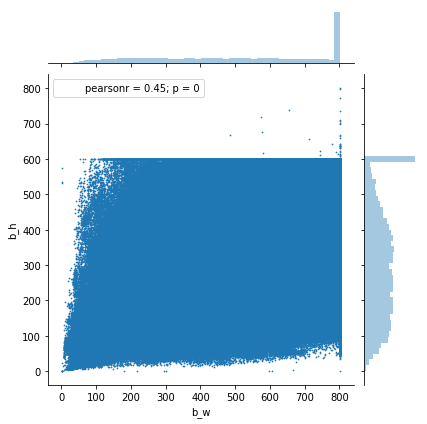

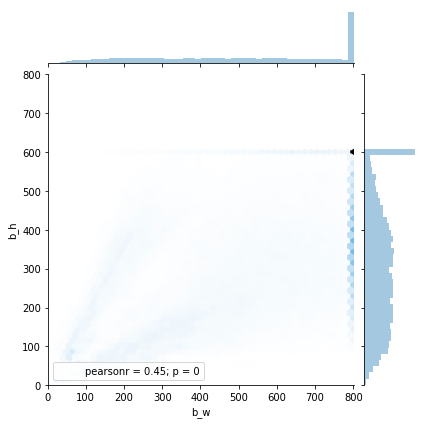

In [9]:
#Joint Plot of b_w and b_h
sns.jointplot(data=data, x="b_w", y="b_h",  kind='scatter', s=0.5)
sns.jointplot(data=data, x="b_w", y="b_h",  kind='hex')

### Calculate the base box size!

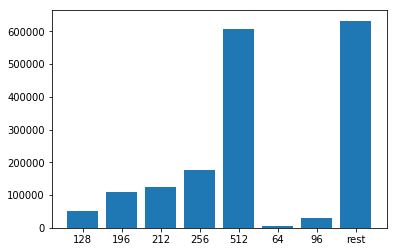

In [10]:
def count_base_size(width, height, input_array=[64,96,128,196,212,256,512]):
    result = {}
    for ele in input_array:
        result[str(ele)] = 0
    result['rest'] = 0
    
    import itertools
    for w,h in zip(width,height):
        done = False
        for inp in input_array:
            if w <= inp and h <= inp:
                result[str(inp)] += 1
                done = True
        if done == False:
            result['rest'] += 1
            
    return result
    
D = count_base_size(data["b_w"].tolist(), data["b_h"].tolist())
import collections
OD = collections.OrderedDict(sorted(D.items()))
plt.bar(range(len(OD)), OD.values(), align='center')  # python 2.x
plt.xticks(range(len(OD)), OD.keys())  # in python 2.x

plt.show()

In [11]:
print(OD)

OrderedDict([('128', 51280), ('196', 108554), ('212', 124874), ('256', 175263), ('512', 608215), ('64', 6600), ('96', 28517), ('rest', 632277)])


In [12]:
# Area Scale
base_box = 256*256
data['b_area_scale'] = (data['w']*data['h']/(base_box)).apply(np.sqrt)
data.describe()

,width,height,xmin,ymin,xmax,ymax,w,h,new_w,new_h,b_w,b_h,b_ar,b_area_scale
count,1240492.0,1240492.0,1.240492e+06,1.240492e+06,1.240492e+06,1.240492e+06,1.240492e+06,1.240492e+06,1240492.0,1240492.0,1.240492e+06,1.240492e+06,1.240492e+06,1.240492e+06
mean,640.0,480.0,1.234385e+02,1.082140e+02,5.133030e+02,3.494357e+02,3.908645e+02,2.422217e+02,800.0,600.0,4.885807e+02,3.027771e+02,1.945816e+00,1.156786e+00
std,0.0,0.0,1.118099e+02,8.037052e+01,1.130370e+02,8.434506e+01,1.905672e+02,1.226866e+02,0.0,0.0,2.382090e+02,1.533582e+02,1.604054e+00,5.171485e-01
min,640.0,480.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,800.0,600.0,1.250000e+00,1.250000e+00,2.173913e-03,3.906250e-03
25%,640.0,480.0,0.000000e+00,3.100000e+01,4.230000e+02,2.850000e+02,2.230000e+02,1.420000e+02,800.0,600.0,2.787500e+02,1.775000e+02,1.100775e+00,7.551904e-01
50%,640.0,480.0,1.150000e+02,1.100000e+02,5.210000e+02,3.370000e+02,3.990000e+02,2.350000e+02,800.0,600.0,4.987500e+02,2.937500e+02,1.720588e+00,1.147135e+00
75%,640.0,480.0,2.130000e+02,1.720000e+02,6.400000e+02,4.190000e+02,5.750000e+02,3.290000e+02,800.0,600.0,7.187500e+02,4.112500e+02,2.455939e+00,1.552193e+00
max,640.0,480.0,6.400000e+02,5.160000e+02,6.400000e+02,6.650000e+02,6.410000e+02,6.400000e+02,800.0,600.0,8.012500e+02,8.000000e+02,6.410000e+02,2.501952e+00


***
## Clusterring using both width & height 

Index(['b_w', 'b_h'], dtype='object')


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


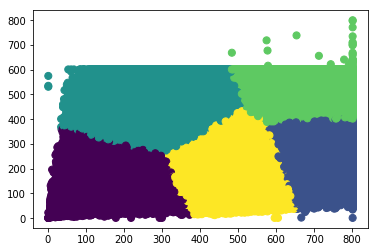

In [13]:
print(data.columns[12:14])
X = data.as_matrix(columns=data.columns[12:14])

from sklearn.cluster import KMeans
K = KMeans(5, random_state=0)
labels = K.fit(X)
plt.scatter(X[:, 0], X[:, 1], c=labels.labels_,
            s=50, cmap='viridis');

In [14]:
out = labels.cluster_centers_

ar = out[:,0]/out[:,1]
scale = out[:,1]*np.sqrt(ar)/256

print("Aspect Ratios: ")
print(ar)

print("Scales: ")
print(scale)

Aspect Ratios: 
[1.27147272 2.61426722 0.69906    1.40863368 2.11080628]
Scales: 
[0.61906169 1.7830958  1.38153448 2.37292033 1.26984176]


***
## IoU based clusterring

In [15]:
#utility functions for K-means
import numpy as np


def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)


def kmeans(boxes, k, dist=np.median):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))

    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]

    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)

        nearest_clusters = np.argmin(distances, axis=1)

        if (last_clusters == nearest_clusters).all():
            break

        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters

    return clusters

In [16]:
print(data.columns[12:14])
X = data.as_matrix(columns=data.columns[12:14])

# Cluster with 4 centers
cl = kmeans(X, 4)
print(cl)

Index(['b_w', 'b_h'], dtype='object')


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


[[487.5  190.  ]
 [240.   358.75]
 [137.5   96.25]
 [738.75 410.  ]]


In [17]:
ar_iou = cl[:,0]/cl[:,1]

print(ar_iou) # Anchor_IoU


scale_iou = cl[:,1]*np.sqrt(ar_iou)/256

print( scale_iou)

[2.56578947 0.66898955 1.42857143 1.80182927]
[1.18884202 1.14620318 0.44937794 2.14981312]
